**Setup:**

In [226]:
%pip install -Uqq fastai
from fastai.vision.all import *

Note: you may need to restart the kernel to use updated packages.


Import MNIST sample that contains samples of all numbers from 0 to 9:

In [227]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
(path/'testing').ls()

(#10) [Path('testing/9'),Path('testing/0'),Path('testing/7'),Path('testing/6'),Path('testing/1'),Path('testing/8'),Path('testing/4'),Path('testing/3'),Path('testing/2'),Path('testing/5')]

Create dictionary `digits` of all digits in MNIST sample:

In [228]:
import os

dir = os.listdir(path/'training')

digits = {}
for digit in dir:
    digits[digit] = (path/'training'/digit).ls().sorted()

Replace image data in dict with ideal image of data:

In [229]:
for digit, data in digits.items():
    digit_tensor = [tensor(Image.open(o)) for o in data]
    stacked_digit = torch.stack(digit_tensor).float()/255
    mean = stacked_digit.mean(0)
    digits[digit] = mean

Show all ideal images:

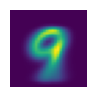

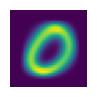

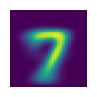

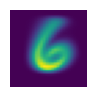

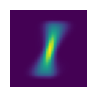

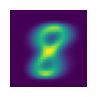

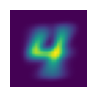

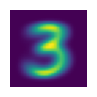

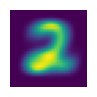

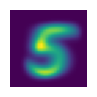

In [230]:
for ideal_image in digits.values():
    show_image(ideal_image)

Calculate distance from every other image:

In [231]:
image_distances = {}
for digit, ideal_image in digits.items():
    digit_dict = {}
    for other_digit, other_image in digits.items():
        if digit == other_digit:
            continue
        digit_dict[other_digit] = (other_image - ideal_image).abs().mean().item()
    image_distances[digit] = digit_dict
image_distances

{'9': {'0': 0.12514999508857727,
  '7': 0.05339561030268669,
  '6': 0.09561774134635925,
  '1': 0.09928193688392639,
  '8': 0.07543418556451797,
  '4': 0.04216742515563965,
  '3': 0.09922107309103012,
  '2': 0.10117614269256592,
  '5': 0.0779072716832161},
 '0': {'9': 0.12514999508857727,
  '7': 0.13578788936138153,
  '6': 0.11681324243545532,
  '1': 0.15632256865501404,
  '8': 0.10512645542621613,
  '4': 0.12406042963266373,
  '3': 0.11110800504684448,
  '2': 0.11675859242677689,
  '5': 0.0904373899102211},
 '7': {'9': 0.05339561030268669,
  '0': 0.13578788936138153,
  '6': 0.11957088112831116,
  '1': 0.09854401648044586,
  '8': 0.0922812670469284,
  '4': 0.07463670521974564,
  '3': 0.10694024711847305,
  '2': 0.11403787136077881,
  '5': 0.09376226365566254},
 '6': {'9': 0.09561774134635925,
  '0': 0.11681324243545532,
  '7': 0.11957088112831116,
  '1': 0.11059906333684921,
  '8': 0.09569879621267319,
  '4': 0.08650808781385422,
  '3': 0.11027486622333527,
  '2': 0.08192884922027588,


Create pairs, prioritizing the lowest overall distances:

In [232]:
all_distances = []
for distance_dict in image_distances.values():
    all_distances += list(distance_dict.values())
all_distances = list(set(all_distances)) # removing duplicates
digit_pairs = []
while len(image_distances) != 0:

    min_distance = min(all_distances)
    for digit, distances in image_distances.items():
        try:
            other_digit = list(distances.keys())[list(distances.values()).index(min_distance)]
            digit_pairs.append((digit, other_digit))
            break
        except ValueError:
            continue

    all_distances.remove(min_distance)
    for i in range(2):
        for distance in image_distances[digit_pairs[-1][i]].values():
            if distance == min_distance:
                continue
            all_distances.remove(distance)
        del image_distances[digit_pairs[-1][i]]

    for distances in image_distances.values():
        for i in range(2):
            try:
                del distances[digit_pairs[-1][i]]
            except KeyError:
                pass
        
digit_pairs
        

[('9', '4'), ('8', '5'), ('3', '2'), ('7', '1'), ('0', '6')]

Create merge of digit pairs:

In [233]:
merge = {}
for digit_pair in digit_pairs:
    merge[digit_pair] = (digits[digit_pair[0]] + digits[digit_pair[1]]) / 2

Show merges:

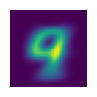

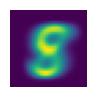

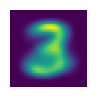

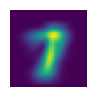

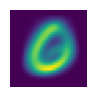

In [234]:
for data in merge.values():
    show_image(data)

Calculate distances between merges:

In [235]:
merge_distances = {}
for digit_pair, ideal_image in merge.items():
    merge_dict = {}
    for other_pair, other_image in merge.items():
        if digit_pair == other_pair:
            continue
        merge_dict[other_pair] = (other_image - ideal_image).abs().mean().item()
    merge_distances[digit_pair] = merge_dict
merge_distances

{('9', '4'): {('8', '5'): 0.06905537098646164,
  ('3', '2'): 0.08635279536247253,
  ('7', '1'): 0.0639469102025032,
  ('0', '6'): 0.09013368934392929},
 ('8', '5'): {('9', '4'): 0.06905537098646164,
  ('3', '2'): 0.05631133168935776,
  ('7', '1'): 0.07090165466070175,
  ('0', '6'): 0.07289887219667435},
 ('3', '2'): {('9', '4'): 0.08635279536247253,
  ('8', '5'): 0.05631133168935776,
  ('7', '1'): 0.07957490533590317,
  ('0', '6'): 0.0782814547419548},
 ('7', '1'): {('9', '4'): 0.0639469102025032,
  ('8', '5'): 0.07090165466070175,
  ('3', '2'): 0.07957490533590317,
  ('0', '6'): 0.10657843947410583},
 ('0', '6'): {('9', '4'): 0.09013368934392929,
  ('8', '5'): 0.07289887219667435,
  ('3', '2'): 0.0782814547419548,
  ('7', '1'): 0.10657843947410583}}

Repeat the same process as above, but leaving one image out:

In [236]:
all_merge_distances = []
for distance_dict in merge_distances.values():
    all_merge_distances += list(distance_dict.values())
all_merge_distances = list(set(all_merge_distances)) # removing duplicates

merge_pairs = []
while len(merge_distances) != 1:

    min_distance = min(all_merge_distances)
    for digit_pair, distances in merge_distances.items():
        try:
            other_pair = list(distances.keys())[list(distances.values()).index(min_distance)]
            merge_pairs.append((digit_pair, other_pair))
            break
        except ValueError:
            continue
    
    all_merge_distances.remove(min_distance)
    for i in range(2):
        for distance in merge_distances[merge_pairs[-1][i]].values():
            if distance == min_distance:
                continue
            all_merge_distances.remove(distance)
        del merge_distances[merge_pairs[-1][i]]
    
    for distances in merge_distances.values():
        for i in range(2):
            try:
                del distances[merge_pairs[-1][i]]
            except KeyError:
                pass
    
last_pair = list(merge_distances.keys())[0]
merge_pairs, last_pair

([(('8', '5'), ('3', '2')), (('9', '4'), ('7', '1'))], ('0', '6'))

Create merged images of the pairs of pairs:

In [237]:
pairs_of_pairs = {}
for merge_pair in merge_pairs:
    pairs_of_pairs[merge_pair] = (merge[merge_pair[0]] + merge[merge_pair[1]]) / 2

Show final merge:

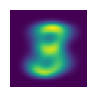

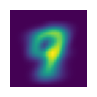

In [238]:
for data in pairs_of_pairs.values():
    show_image(data)

Get distance between lone pair and each merge:

In [239]:
lone_distance = {}
for key, data in pairs_of_pairs.items():
    lone_distance[key] = (merge[last_pair] - data).abs().mean().item()
lone_distance

{(('8', '5'), ('3', '2')): 0.07169119268655777,
 (('9', '4'), ('7', '1')): 0.0934680849313736}

Get final pairs:

In [243]:
print(f"Pairs:\n{digit_pairs[0][0]} and {digit_pairs[0][1]}, {digit_pairs[1][0]} and {digit_pairs[1][1]}, {digit_pairs[2][0]} and {digit_pairs[2][1]}, {digit_pairs[3][0]} and {digit_pairs[3][1]}, {digit_pairs[4][0]} and {digit_pairs[4][1]}\n")
print(f"Groups:\n{digit_pairs[1][0]} and {digit_pairs[1][1]} and {digit_pairs[2][0]} and {digit_pairs[2][1]} and {digit_pairs[4][0]} and {digit_pairs[4][1]}, {digit_pairs[0][0]} and {digit_pairs[0][1]} and {digit_pairs[3][0]} and {digit_pairs[3][1]}")

Pairs:
9 and 4, 8 and 5, 3 and 2, 7 and 1, 0 and 6

Groups:
8 and 5 and 3 and 2 and 0 and 6, 9 and 4 and 7 and 1
